<a href="https://colab.research.google.com/github/Orth33/oyster-binary-classification/blob/main/Oyster_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**1. Imports & Environment Setup**

In [ ]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

from torchvision import datasets, transforms, models

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    auc
)

In [ ]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

####**2. Dataset Loading & Exploration**

In [ ]:
# Training data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation / Test transforms (NO augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
oyster_classification_dataset_path = kagglehub.dataset_download("darun04/oyster-classification")
print('Data source import complete.')
print("Path to dataset files:", oyster_classification_dataset_path)

Using Colab cache for faster access to the 'oyster-classification' dataset.
Data source import complete.
Path to dataset files: /kaggle/input/oyster-classification


In [ ]:
data_dir = "/kaggle/input/oyster-classification/Oyster Data set"

full_dataset = datasets.ImageFolder(root=data_dir)
class_names = full_dataset.classes
class_names


['Oyster Images', 'Oyster Spat Images']

In [ ]:
#Split dataset
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Assign transforms AFTER splitting
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform   = test_transforms
test_dataset.dataset.transform  = test_transforms

In [ ]:
#Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
#Class imbalance check

from collections import Counter

labels = [label for _, label in full_dataset]
print(Counter(labels))

Counter({0: 745, 1: 612})


####**3. Model selection (Pretrained architecture)**

In [ ]:
model = models.resnet18(pretrained=True)

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

####**4. Training setup**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

In [ ]:
num_epochs = 20
patience = 5
early_stop_counter = 0

train_losses = []
val_losses = []

best_val_loss = float("inf")

for epoch in range(num_epochs):
    # -------- Training --------
    model.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # -------- Validation --------
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {epoch_train_loss:.4f} "
        f"Val Loss: {epoch_val_loss:.4f}"
    )

    # -------- Early Stopping Logic --------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch [1/20] Train Loss: 0.6990 Val Loss: 0.6324
Epoch [2/20] Train Loss: 0.6072 Val Loss: 0.5633
Epoch [3/20] Train Loss: 0.5334 Val Loss: 0.4896
Epoch [4/20] Train Loss: 0.4773 Val Loss: 0.4373
Epoch [5/20] Train Loss: 0.4246 Val Loss: 0.4013
Epoch [6/20] Train Loss: 0.4001 Val Loss: 0.3591
Epoch [7/20] Train Loss: 0.3568 Val Loss: 0.3350
Epoch [8/20] Train Loss: 0.3404 Val Loss: 0.3108
Epoch [9/20] Train Loss: 0.3078 Val Loss: 0.2899
Epoch [10/20] Train Loss: 0.2940 Val Loss: 0.2744
Epoch [11/20] Train Loss: 0.2689 Val Loss: 0.2571
Epoch [12/20] Train Loss: 0.2620 Val Loss: 0.2463
Epoch [13/20] Train Loss: 0.2532 Val Loss: 0.2321
Epoch [14/20] Train Loss: 0.2384 Val Loss: 0.2254
Epoch [15/20] Train Loss: 0.2290 Val Loss: 0.2122
Epoch [16/20] Train Loss: 0.2235 Val Loss: 0.2058
Epoch [17/20] Train Loss: 0.2096 Val Loss: 0.1975
Epoch [18/20] Train Loss: 0.1975 Val Loss: 0.1920
Epoch [19/20] Train Loss: 0.1942 Val Loss: 0.1844
Epoch [20/20] Train Loss: 0.1978 Val Loss: 0.1764


####**5. Evaluation**

In [ ]:
model.eval()

train_true = []
train_pred = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())

train_accuracy = accuracy_score(train_true, train_pred)
train_prec = precision_score(train_true, train_pred, average="macro")
train_rec = recall_score(train_true, train_pred, average="macro")
train_f1 = f1_score(train_true, train_pred, average="macro")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1-score: {train_f1:.4f}")

Training Accuracy: 0.9631
Training Precision: 0.9627
Training Recall: 0.9625
Training F1-score: 0.9626


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:,1]

        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

In [ ]:
test_acc = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred, average="macro")
test_rec = recall_score(y_true, y_pred, average="macro")
test_f1 = f1_score(y_true, y_pred, average="macro")

In [ ]:
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro Precision: {test_prec:.4f}")
print(f"Macro Recall: {test_rec:.4f}")
print(f"Macro F1-score: {test_f1:.4f}")

Accuracy: 0.9756
Macro Precision: 0.9744
Macro Recall: 0.9769
Macro F1-score: 0.9754


In [ ]:
print("Accuracy Comparison")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Gap:               {abs(train_accuracy - test_acc):.4f}")

Accuracy Comparison
Training Accuracy: 0.9631
Test Accuracy:     0.9756
Gap:               0.0125


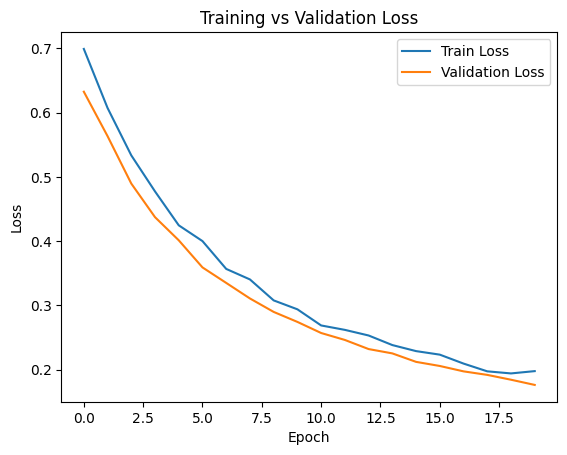

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

***Confusion Matrix***

Confusion Matrix Heatmap Generated.


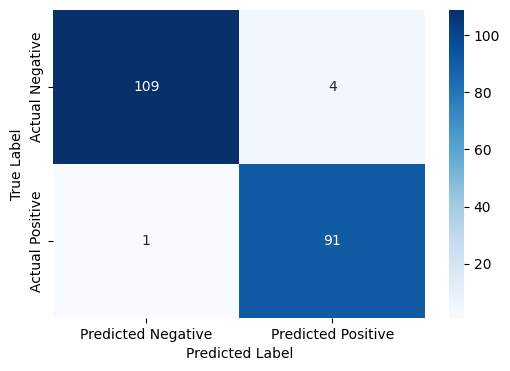

In [ ]:
# Calculate CM
cm = confusion_matrix(y_true, y_pred)

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print("Confusion Matrix Heatmap Generated.")
plt.show()

***ROC Curve***

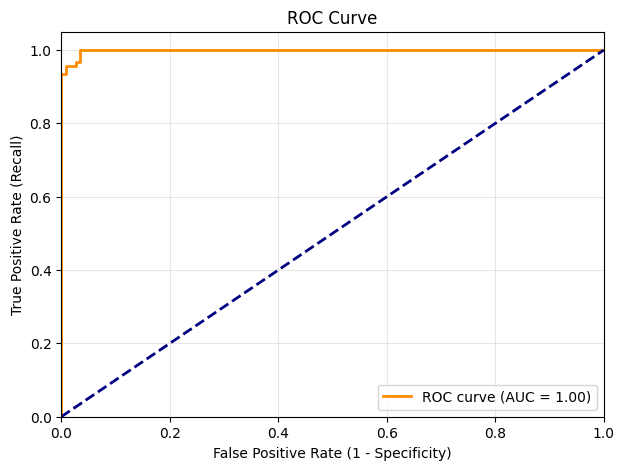

In [ ]:
# 1. Calculate AUC
auc = roc_auc_score(y_true, y_prob)

# 2. Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# 3. Plotting
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()